In [1]:
# --- paths you might customize ---
MODEL_PATH = "disaster-ai/models/cv/resnet18_xbd_binary.pt"   # from step 4
DATA_DIR   = "disaster-ai/data/xbd/tier1"                      # or any folder with *post*disaster*.png
OUT_DIR    = "disaster-ai/outputs/inference"

import os, json, math
from pathlib import Path
os.makedirs(OUT_DIR, exist_ok=True)

import torch
from torch import nn
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
CLASSES = ["no-damage","damage"]  # binary model

Device: mps


In [3]:
IMG_SIZE = 224
tf_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [5]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(MODEL_PATH, map_location="cpu")
model.load_state_dict(ckpt)
model.to(device).eval()
print("Model loaded:", MODEL_PATH)

Model loaded: disaster-ai/models/cv/resnet18_xbd_binary.pt


In [7]:
def list_post_images(root: str | Path):
    root = Path(root)
    return sorted(root.rglob("*post*disaster*.png"))

def predict_image(path: str | Path, threshold: float = 0.5):
    img = Image.open(path).convert("RGB")
    x = tf_eval(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = logits.softmax(1).squeeze(0).cpu().numpy()
    p_damage = float(probs[1])
    label = CLASSES[1] if p_damage >= threshold else CLASSES[0]
    return p_damage, label, img

def show_preds_grid(paths, threshold=0.5, cols=4, max_images=12):
    picks = paths[:max_images]
    rows = math.ceil(len(picks)/cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i,p in enumerate(picks):
        p_damage, label, img = predict_image(p, threshold)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(f"{Path(p).name}\n{label}  (p={p_damage:.2f})", fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def maybe_mask_path(img_path: Path) -> Path | None:
    """
    If you have masks (e.g., *_post_disaster_rgb.png) alongside labels/images,
    try to resolve a sibling path. This is optional.
    """
    p = Path(img_path)
    # .../images/file_post_disaster.png  ->  ../masks/file_post_disaster_rgb.png
    if p.parent.name == "images":
        cand = p.parent.parent/"masks"/(p.stem + "_rgb.png")
        return cand if cand.exists() else None
    # or same dir
    cand2 = p.with_name(p.stem + "_rgb.png")
    return cand2 if cand2.exists() else None

In [9]:
import csv
from datetime import datetime

def run_folder_inference(data_dir=DATA_DIR, threshold=0.5, limit=None):
    paths = list_post_images(data_dir)
    if limit is not None:
        paths = paths[:limit]
    rows = [("image_path","prob_damage","pred_label")]
    for p in paths:
        pdmg, lab, _ = predict_image(p, threshold)
        rows.append((str(p), f"{pdmg:.6f}", lab))

    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_csv = Path(OUT_DIR)/f"preds_{stamp}.csv"
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerows(rows)
    print(f"Wrote: {out_csv}  ({len(rows)-1} rows)")
    return out_csv, paths

# run it
csv_path, img_paths = run_folder_inference(DATA_DIR, threshold=0.5, limit=200)

Wrote: disaster-ai/outputs/inference/preds_20250924_154745.csv  (200 rows)


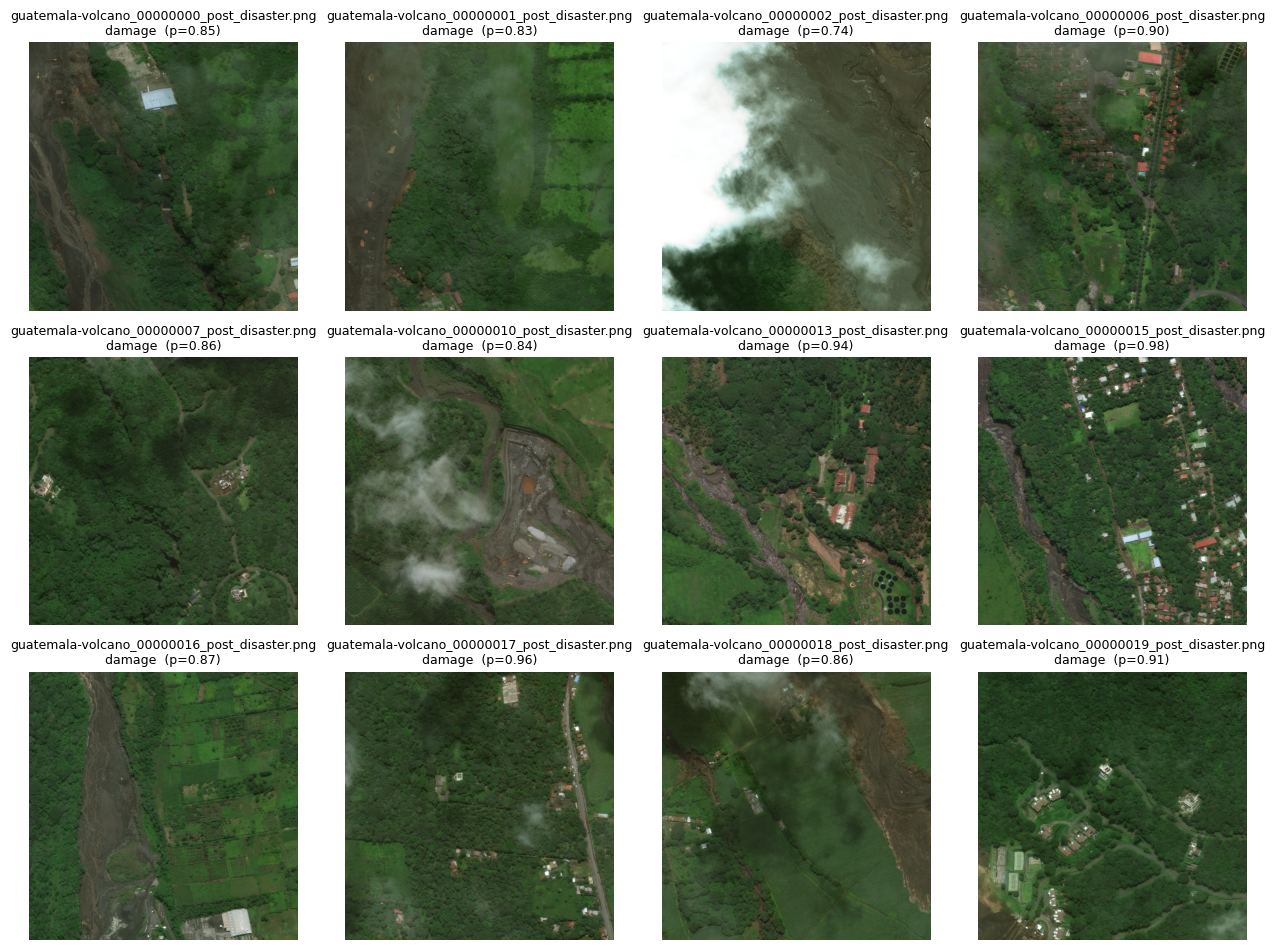

In [11]:
show_preds_grid(img_paths, threshold=0.5, cols=4, max_images=12)

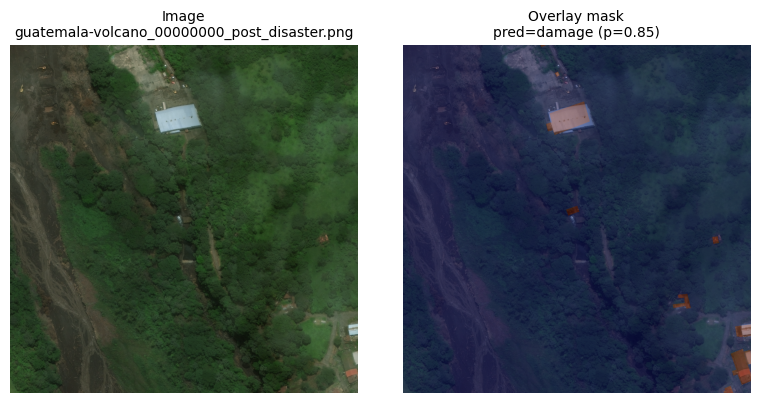

In [13]:
def show_with_mask(img_path: str | Path, threshold=0.5):
    p = Path(img_path)
    pdmg, label, rgb = predict_image(p, threshold)
    mpath = maybe_mask_path(p)

    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1); ax1.imshow(rgb); ax1.axis("off")
    ax1.set_title(f"Image\n{Path(p).name}", fontsize=10)

    if mpath and mpath.exists():
        mask = Image.open(mpath).convert("L")
        ax2 = plt.subplot(1,2,2); ax2.imshow(rgb)
        ax2.imshow(mask, alpha=0.35, cmap="jet")
        ax2.axis("off")
        ax2.set_title(f"Overlay mask\npred={label} (p={pdmg:.2f})", fontsize=10)
    else:
        ax2 = plt.subplot(1,2,2); ax2.imshow(rgb); ax2.axis("off")
        ax2.set_title(f"No mask found\npred={label} (p={pdmg:.2f})", fontsize=10)

    plt.tight_layout(); plt.show()

# try one
if img_paths:
    show_with_mask(img_paths[0])

In [17]:
# how many eval images actually have zero-mask (true "no-damage")?
from pathlib import Path
import numpy as np
from PIL import Image

def maybe_mask_path(img_path: Path):
    if img_path.parent.name == "images":
        cand = img_path.parent.parent/"masks"/(img_path.stem + "_rgb.png")
        if cand.exists(): return cand
    cand2 = img_path.with_name(img_path.stem + "_rgb.png")
    return cand2 if cand2.exists() else None

paths = sorted(Path(DATA_DIR).rglob("*post*disaster*.png"))[:800]
t0 = t1 = 0
for p in paths:
    mp = maybe_mask_path(p)
    if not (mp and mp.exists()):
        continue
    y = int(np.array(Image.open(mp).convert("L")).sum() > 0)
    t1 += y==1
    t0 += y==0
print("Eval with masks -> no-damage:", t0, "| damage:", t1)

Eval with masks -> no-damage: 47 | damage: 753


Best F1=0.970 at threshold=0.539


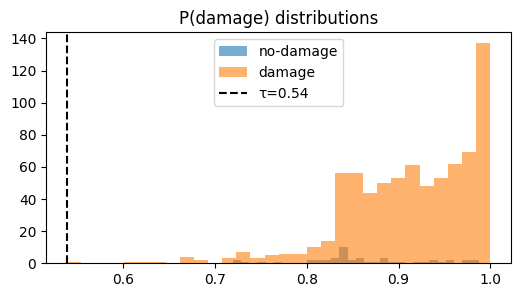

In [23]:
# collect scores + labels from the same 800 eval tiles
import numpy as np
from PIL import Image
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def predict_prob(img_path):
    img = Image.open(img_path).convert("RGB")
    x = tf_eval(img).unsqueeze(0).to(device)   # use the same eval transform you used in training
    with torch.no_grad():
        p = model(x).softmax(1)[0,1].item()    # P(damage)
    return p

y_true, y_score, kept = [], [], []
for p in paths:                           # 'paths' you already built above
    mp = maybe_mask_path(p)
    if not (mp and mp.exists()):
        continue
    y = int(np.array(Image.open(mp).convert("L")).sum() > 0)  # 1=damage, 0=no-damage
    y_true.append(y)
    y_score.append(predict_prob(p))
    kept.append(p)

y_true = np.array(y_true); y_score = np.array(y_score)

# pick threshold that maximizes F1 (or change to maximize balanced accuracy if you prefer)
prec, rec, th = precision_recall_curve(y_true, y_score)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_i = f1.argmax()
best_thresh = th[best_i] if best_i < len(th) else 0.5
print(f"Best F1={f1[best_i]:.3f} at threshold={best_thresh:.3f}")

# visualize score distributions
plt.figure(figsize=(6,3))
plt.hist(y_score[y_true==0], bins=30, alpha=0.6, label="no-damage")
plt.hist(y_score[y_true==1], bins=30, alpha=0.6, label="damage")
plt.axvline(best_thresh, color="k", ls="--", label=f"τ={best_thresh:.2f}")
plt.legend(); plt.title("P(damage) distributions"); plt.show()

              precision    recall  f1-score   support

   no-damage      0.000     0.000     0.000        47
      damage      0.941     1.000     0.970       753

    accuracy                          0.941       800
   macro avg      0.471     0.500     0.485       800
weighted avg      0.886     0.941     0.913       800



/opt/anaconda3/envs/tfm3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tfm3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tfm3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

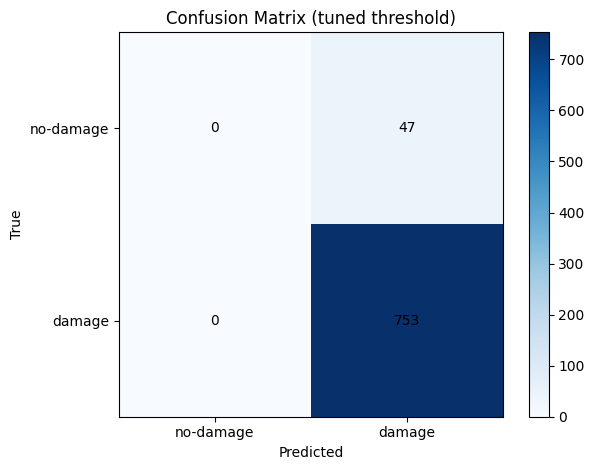

In [25]:
y_pred = (y_score >= best_thresh).astype(int)
print(classification_report(y_true, y_pred, target_names=["no-damage","damage"], digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], ["no-damage","damage"]); plt.yticks([0,1], ["no-damage","damage"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j], ha="center", va="center", color="black")
plt.title("Confusion Matrix (tuned threshold)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

Class balance in eval -> no-damage: 665 | damage: 2335
              precision    recall  f1-score   support

   no-damage       0.84      0.62      0.72       665
      damage       0.90      0.97      0.93      2335

    accuracy                           0.89      3000
   macro avg       0.87      0.80      0.82      3000
weighted avg       0.89      0.89      0.88      3000



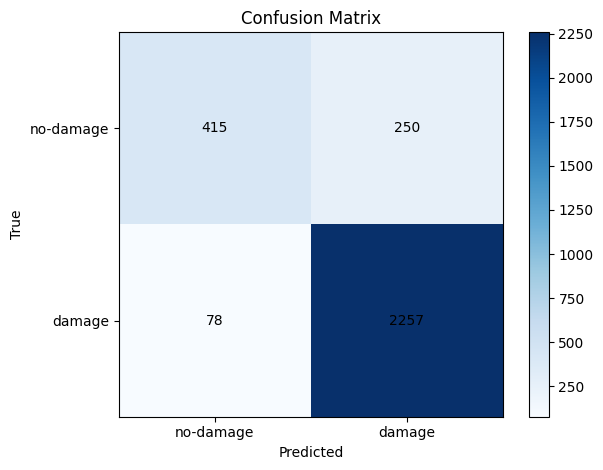

In [29]:
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

AREA_MIN = 50  # ignore tiny specks; tune 10–200

def hard_label_from_mask(mp) -> int:
    if (mp is None) or (not mp.exists()):
        return 0
    arr = np.array(Image.open(mp).convert("L"))
    return int((arr > 0).sum() > AREA_MIN)

# collect all post-disaster tiles (don’t filter by mask existence)
paths = sorted(Path(DATA_DIR).rglob("*post*disaster*.png"))

y_true, y_prob = [], []
model.eval()
with torch.no_grad():
    for p in paths[:3000]:  # use more than 800 for a better mix
        mp = maybe_mask_path(p)
        y = hard_label_from_mask(mp)
        x = tf_eval(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
        prob = model(x).softmax(1)[0,1].item()   # P(damage)
        y_true.append(y); y_prob.append(prob)

y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("Class balance in eval -> no-damage:",
      (y_true==0).sum(), "| damage:", (y_true==1).sum())
print(classification_report(y_true, y_pred, target_names=["no-damage", "damage"], zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], ["no-damage","damage"]); plt.yticks([0,1], ["no-damage","damage"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha="center",va="center",color="black")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()